# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#Importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from datetime import datetime
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


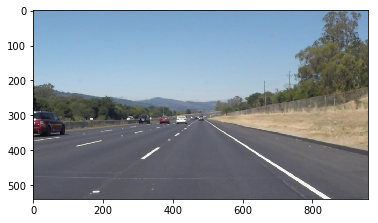

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Functions

Below are all the functions that were utilized for this project. Most of them are from the class.

In [3]:
# INPUT FUNCTIONS #
def load_raw(folder):
    ## LOAD IMAGES ##
    # Takes in a folder name as an input, and loads all images for ease.
    raw_images=[]
    for filename in os.listdir(folder):
        raw_image=mpimg.imread(os.path.join(folder,filename))
        if raw_image is not None:
            raw_images.append(raw_image)    
    return raw_images # All images in folder.

# MANIPULATION FUNCTIONS #
def hsl_lanefilter(raw_image,low_whitethreshold,high_whitethreshold,low_yellowthreshold,high_yellowthreshold):
    ## LANE FILTER EXTRACTION ##
    # Uses an HSL color palette/range to make lane line extraction more robust (yellow, white lines), returns an RGB image.
    image_hls=cv2.cvtColor(raw_image,cv2.COLOR_BGR2HLS)
    # White filtering
    white_lane=cv2.inRange(image_hls,low_whitethreshold,high_whitethreshold)
    # Yellow filtering
    yellow_lane=cv2.inRange(image_hls,low_yellowthreshold,high_yellowthreshold)
    whiteyellow_lanes_mask=cv2.bitwise_or(white_lane,yellow_lane)
    image_hslmaskedlines=cv2.bitwise_and(raw_image,raw_image,whiteyellow_lanes_mask)
    return image_hslmaskedlines 
    
def grayscale(raw_image):
    ## GRAYSCALE CONVERSION ##
    # Convert RGB image to grayscale.
    image_gray=cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY) 
    return image_gray

def gaussian_blur(raw_image,kernel_dimx,kernel_dimy,s_dev):
    ## GAUSSIAN BLUR ##
    # Smooth a grayscale image to remove noise.
    image_blur=cv2.GaussianBlur(raw_image,(kernel_dimx,kernel_dimy),s_dev) 
    return image_blur

def canny(raw_image,low_threshold,high_threshold):
    ## CANNY-EDGE DETECTION ##
    # Detect edges by identifying regions of high pixel-gradients.
    image_canny=cv2.Canny(raw_image,low_threshold,high_threshold) 
    return image_canny

def region_of_interest(raw_image,vertices):
    ## PROCESSING REGION MASK ##
    # Focus and implement a trapezoidal mask where we assume the road will always be.
    ROI_mask=np.zeros_like(raw_image) # Empty Region of Interest mask.
     
    if len(raw_image.shape)>2: # Mask color fill depending on number of channels.
        channel_count=raw_image.shape[2]
        ignore_mask_color=(255,)*channel_count
    else:
        ignore_mask_color=255
    
    cv2.fillPoly(ROI_mask,vertices,ignore_mask_color) # Fill a polygon defined by ROI mask with the ignore_mask_color.
    image_ROImaskededge=cv2.bitwise_and(raw_image,ROI_mask) # Regions where mask and edges are true.
    return image_ROImaskededge

def left_right_separation(midpoint,lines):
    ##LINE DRAWING SUB-FUNCTION##
    # From an image midpoint, separate lane lines into left, and right lanes. 
    left_lines=[]
    right_lines=[]
    
    for line in lines:
        x1,y1,x2,y2=line[0]
        # Selection is done by comparing both x-coordinates input to the x-midpoint of the image.
        if (x1<midpoint[1] and x2<midpoint[1]):
            left_lines.append(line)
        elif (x1>midpoint[1] and x2>midpoint[1]):
            right_lines.append(line)
    return left_lines,right_lines
                
def gradient(x1,y1,x2,y2):
    ##LINE DRAWING SUB-FUNCTION##
    # From two coordinate points, obtain the gradient.
    Valid=True
    if (x2-x1)!=0:
        gradient=float(y2-y1)/float(x2-x1)
    else:
        # Checks to ensure gradient isn't horizontal (false positive).
        Valid=False
    return Valid,gradient

def get_points(raw_image,line):
    ##LINE DRAWING SUB-FUNCTION##
    # Polyfits line to be drawn using y-positions.
    X=[];Y=[];
    y_start=raw_image.shape[0]
    y_end=0.65*raw_image.shape[0]
    for x1,y1,x2,y2 in line:
        X.append(x1)
        X.append(x2)
        Y.append(y1)
        Y.append(y2)
    gradient,intercept=np.polyfit(X,Y,1) # Linear polyfit of y=m*x+b.
    x_start=(y_start-intercept)/gradient
    x_end=(y_end-intercept)/gradient
    # Will give an error/ false lane-line if the lanes curve steeply or are at an incline.
    return x_start,y_start,x_end,y_end

def line_length(line):
    ##LINE DRAWING SUB-FUNCTION##
    # From two coordinate points, obtain the length.
    for x1,y1,x2,y2 in line:
        length=np.sqrt(np.power(y2-y1,2)+np.power(x2-x1,2))
    return length

def draw_lines(raw_image,lines):
    ## MAIN DRAWING FUNCTION ##
    ## Uses line-separation, gradients, and get points sub-functions #
    image_midpoint=[0.5*raw_image.shape[0],0.5*raw_image.shape[1]]
    l_lines,r_lines=left_right_separation(image_midpoint,lines)

    left_gradients=[]; chosen_left=[]
    right_gradients=[]; chosen_right=[]
    left_valid=[];right_valid=[];
    for candidate_left in l_lines:
        for x1,y1,x2,y2 in candidate_left:
            left_valid,left_gradient=gradient(x1,y1,x2,y2)
            if (np.absolute(left_gradient)>0.5 and left_valid):
                left_gradients.append(left_gradient)
                chosen_left.append(candidate_left)

    for candidate_right in r_lines:
        for x1,y1,x2,y2 in candidate_right:
            right_valid,right_gradient=gradient(x1,y1,x2,y2)
            if (np.absolute(right_gradient)>0.5 and right_valid):
                right_gradients.append(right_gradient)
                chosen_right.append(candidate_right)
   
    for line in chosen_left:
        x_sl,y_sl,x_el,y_el=get_points(raw_image,line)
        cv2.line(raw_image,(int(x_sl),int(y_sl)),(int(x_el),int(y_el)),(255,0,0),10)
    
    for line in chosen_right:
        x_sr,y_sr,x_er,y_er=get_points(raw_image,line)
        cv2.line(raw_image,(int(x_sr),int(y_sr)),(int(x_er),int(y_er)),(255,0,0),10)
    
def hough_lines(raw_image,rho,theta,votes_threshold,min_line_len,max_line_gap):
    ## HOUGH LINES ##
    # Extracting hough features/lines that satisfy specified parameters from input canny-edge image.
    # Returns an image with drawn hough lines
    houghlines=cv2.HoughLinesP(raw_image,rho,theta,votes_threshold,\
                                     np.array([]),min_line_len,max_line_gap) 
        # Convert Canny Edge points into candidate lines that could be either lane lines or noise.
    image_drawnhough=np.zeros((raw_image.shape[0],raw_image.shape[1],3),dtype=np.uint8)
    draw_lines(image_drawnhough,houghlines)
    return image_drawnhough

def weighted_image(raw_image_preprocessed,image_processed,alpha,beta):
    ## COMBINATION OF IMAGES ##
    # Blending weighted images.
    # (initial_img*α) + (img*β) + λ where initial_image is the preprocessed image, and img is the blank image with hough lines.
    image_weighted=cv2.addWeighted(raw_image_preprocessed,alpha,image_processed,beta,0) 
    return image_weighted

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

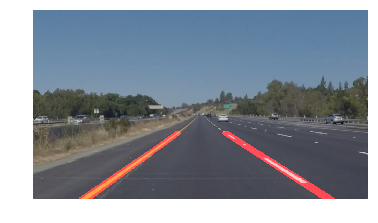

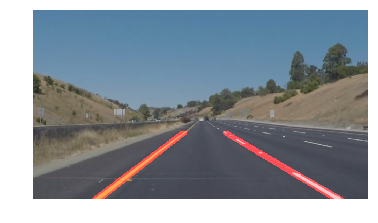

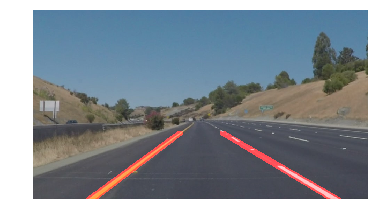

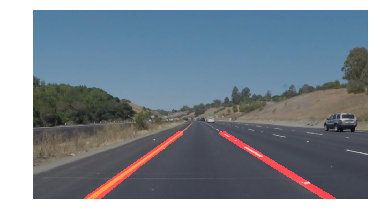

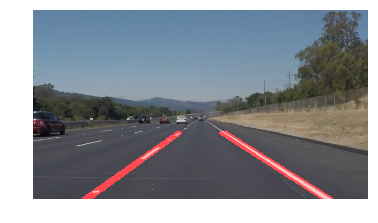

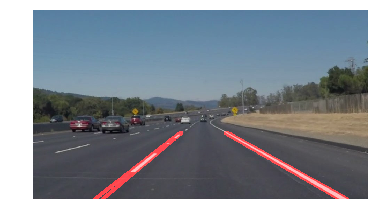

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def lanefinding_pipeline(raw_input_image):
## Start Lane-Finding Pipeline ##
    """
Function that takes in an image and outputs an image with detected lane lines. The input image is converted to grayscale, 
smoothed using gaussian blurring, and high-color gradient thresholds are detected using Canny-Edge detection. 
A Region-of-Interest polygon mask is applied as an area to focus on. Following this, lane features are extracted using Hough Transform
and then merged to form the final detected image.
    """
    raw_image_copy=np.copy(raw_input_image) # Create a copy of the raw image for manipulation.
    image_shape=raw_input_image.shape # Extract raw image size.
    image_blank=np.copy(raw_image_copy)*0 # Blank template of desired size to layer Hough Transform lines.

    ### TUNING PARAMETERS ###
    # HSL colorspace conversion #
    param_whight=np.array([255,255,255],np.uint8)
    param_wlowt=np.array([0,200,0],np.uint8)
    param_yhight=np.array([40,255,255],np.uint8)
    param_ylowt=np.array([10,0,100],np.uint8)
    # Gaussian Blur #
    param_kernel=9 # Kernel size.
    param_sigma=0 # Standard deviation.
    # Canny-Edge Detection #
    param_low_threshold=50 # Low gradient threshold.
    param_high_threshold=150 # High gradient threshold.
    # Hough-Transformation #
    param_rho=1 # Smallest distance from origin (pixels).
    param_theta=np.pi/180 # Smallest angle from horizontal (radians).
    param_vthreshold=40 # Minimum votes in a grid cell for a candidate.
    param_min_len=20 # Minimum length of line that will be accepted (pixels).
    param_max_gap=150 # Maximum gap between segments to form a line (pixels).
    # Weighted Mixing of images #
    param_weight_one=0.8 # Weighting factor (first image).
    param_weight_two=1.5 # Weighting factor (second image).
    ### END TUNING PARAMETERS ###

    ### IMAGE MANIPULATION ###
    ## HUE-SATURATION-LIGHTNESS FILTERING ##
    image_hslfiltering=hsl_lanefilter(raw_image_copy,param_wlowt,param_whight,param_ylowt,param_yhight)
   
    ## GRAYSCALE CONVERSION ##
    image_gray=grayscale(image_hslfiltering)
   
    ## GAUSSIAN BLUR ##
    image_blur=gaussian_blur(image_gray,param_kernel,param_kernel,param_sigma)
    
    ## CANNY-EDGE DETECTION ##
    image_canny=canny(image_blur,param_low_threshold,param_high_threshold) 
    
    ## REGION-OF-INTEREST MASK ##
    vertex_bl=(0.03*image_shape[1],image_shape[0])
    vertex_tl=(0.45*image_shape[1],0.60*image_shape[0])
    vertex_tr=(0.52*image_shape[1],0.60*image_shape[0])
    vertex_br=(0.97*image_shape[1],image_shape[0])
    vertices=np.array([[vertex_bl,vertex_tl,vertex_tr,vertex_br]], dtype=np.int32)
    ROImask=region_of_interest(image_canny,vertices)
    
    ## HOUGH FEATURE EXTRACTION ##
    image_houghextract=hough_lines(ROImask,param_rho,param_theta,param_vthreshold,param_min_len,param_max_gap)
    
    ## LAYERING HOUGH LINES ON ORIGINAL IMAGE ##
    image_color_canny=np.dstack((image_canny,image_canny,image_canny)) # Color stack of Canny Edge image (third dimension)
    image_lanedetect=weighted_image(raw_image_copy,image_houghextract,param_weight_one,param_weight_two)
    
    plt.imshow(image_lanedetect)
    plt.show()
    ### END IMAGE MANIPULATION ###
## End Lane-Finding Pipeline ##

### INPUTS ###
imgfolder='test_images/'
imgfolder_output="test_images_output/"
for item in load_raw(imgfolder):
    plt.axis('off')
    lanefinding_pipeline(item)
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(raw_input_image):
# NOTE: The output you return should be a color image (3 channel) for processing video below
# TODO: put your pipeline here,
# you should return the final output (image where lines are drawn on lanes)
## Start Lane-Finding Pipeline ##
    """
Function that takes in an image and outputs an image with detected lane lines. The input image is converted to grayscale, 
smoothed using gaussian blurring, and high-color gradient thresholds are detected using Canny-Edge detection. 
A Region-of-Interest polygon mask is applied as an area to focus on. Following this, lane features are extracted using Hough Transform
and then merged to form the final detected image.
    """
    raw_image_copy=np.copy(raw_input_image) # Create a copy of the raw image for manipulation.
    image_shape=raw_input_image.shape # Extract raw image size.
    image_blank=np.copy(raw_image_copy)*0 # Blank template of desired size to layer Hough Transform lines.

    ### TUNING PARAMETERS ###
    # HSL colorspace conversion #
    param_whight=np.array([255,255,255],np.uint8)
    param_wlowt=np.array([0,200,0],np.uint8)
    param_yhight=np.array([40,255,255],np.uint8)
    param_ylowt=np.array([10,0,100],np.uint8)
    # Gaussian Blur #
    param_kernel=11 # Kernel size.
    param_sigma=0 # Standard deviation.
    # Canny-Edge Detection #
    param_low_threshold=50 # Low gradient threshold.
    param_high_threshold=200 # High gradient threshold.
    # Hough-Transformation #
    param_rho=1 # Smallest distance from origin (pixels).
    param_theta=np.pi/180 # Smallest angle from horizontal (radians).
    param_vthreshold=40 # Minimum votes in a grid cell for a candidate.
    param_min_len=40 # Minimum length of line that will be accepted (pixels).
    param_max_gap=150 # Maximum gap between segments to form a line (pixels).
    # Weighted Mixing of images #
    param_weight_one=0.8 # Weighting factor (first image).
    param_weight_two=1.5 # Weighting factor (second image).
    ### END TUNING PARAMETERS ###

    ### IMAGE MANIPULATION ###
    ## HUE-SATURATION-LIGHTNESS FILTERING ##
    image_hslfiltering=hsl_lanefilter(raw_image_copy,param_wlowt,param_whight,param_ylowt,param_yhight)
   
    ## GRAYSCALE CONVERSION ##
    image_gray=grayscale(image_hslfiltering)
   
    ## GAUSSIAN BLUR ##
    image_blur=gaussian_blur(image_hslfiltering,param_kernel,param_kernel,param_sigma)
    
    ## CANNY-EDGE DETECTION ##
    image_canny=canny(image_blur,param_low_threshold,param_high_threshold) 
    
    ## REGION-OF-INTEREST MASK ##
    vertex_bl=(0.05*image_shape[1],image_shape[0])
    vertex_tl=(0.45*image_shape[1],0.50*image_shape[0])
    vertex_tr=(0.52*image_shape[1],0.50*image_shape[0])
    vertex_br=(0.95*image_shape[1],image_shape[0])
    vertices=np.array([[vertex_bl,vertex_tl,vertex_tr,vertex_br]], dtype=np.int32)
    
#     vertex_bl=(0.05*image_shape[1],image_shape[0])
#     vertex_t=(0.50*image_shape[1],0.50*image_shape[0])
#     vertex_br=(0.95*image_shape[1],image_shape[0])
#     vertices=np.array([[vertex_bl,vertex_t,vertex_br]], dtype=np.int32)
    ROImask=region_of_interest(image_canny,vertices)
    
    ## HOUGH FEATURE EXTRACTION ##
    image_houghextract=hough_lines(ROImask,param_rho,param_theta,param_vthreshold,param_min_len,param_max_gap)
    
    ## LAYERING HOUGH LINES ON ORIGINAL IMAGE ##
    image_color_canny=np.dstack((image_canny,image_canny,image_canny)) # Color stack of Canny Edge image (third dimension)
    image_lanedetect=weighted_image(raw_image_copy,image_houghextract,param_weight_one,param_weight_two)
    
    return image_lanedetect
    ### END IMAGE MANIPULATION ###
## End Lane-Finding Pipeline ##

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:15<00:00, 13.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 15.5 s, sys: 1.1 s, total: 16.6 s
Wall time: 17.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:46<00:00, 15.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 49.1 s, sys: 2.36 s, total: 51.5 s
Wall time: 47.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:30<00:00,  9.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 26.9 s, sys: 656 ms, total: 27.5 s
Wall time: 32.5 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
print("Script terminated at",str(datetime.now()))